In [1]:
#restart the kernel if switching from inline to notebook
import matplotlib.pyplot as plt
%matplotlib notebook 
plt.style.use('seaborn-whitegrid')
import corner

import numpy as np
import numpy.linalg
import scipy.stats
from scipy.signal import argrelextrema
import pandas as pd

import emcee
import george

from subsample import subsample # daniela's code
from emcee_utils import walker_params, plot_gpfit
#from plotting import plot_steps
from plotting import plot_lightcurve, plot_folded_lightcurve, plot_mcmc_sampling_results, plot_steps

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/dynesty/bounding.py:73: UserWarning: Robust OAS shrunk covariance estimator from `sklearn` is not available. Defaulting to MLE estimator from `numpy`.
  warnings.warn("Robust OAS shrunk covariance estimator from `sklearn` is "


In [17]:
def prior(params):

    """
    Calculated the log of the prior values, given parameter values.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    param[0] : float
        mean (between 0 and 2)

    param[1] : float
        log amplitude (between -10 and 10)

    param[2] : float
        gamma (log gamma between 0.1 and 40)

    param[3] : float
        log period (period between 1h and 24hrs)

    Returns
    -------
    sum_log_prior : int
        sum of all log priors (-inf if a parameter is out of range)

    """

    p_mean = scipy.stats.norm(1, 0.5).logpdf(params[0])
    p_log_amp = scipy.stats.norm(np.log(0.15), np.log(2)).logpdf(params[1])
    p_log_gamma = scipy.stats.norm(np.log(10), np.log(2)).logpdf(np.log(params[2]))
    p_period = scipy.stats.norm(np.log(4./24.), (12./24.)).logpdf(params[3])
    
    sum_log_prior =  p_mean + p_log_amp + p_log_gamma + p_period

    if np.isnan(sum_log_prior) == True:
        return -np.inf

    return sum_log_prior

def logl(params, gp, tsample, fsample, flux_err):
    # compute lnlikelihood based on given parameters
    gp.set_parameter_vector(params)

    try:
        gp.compute(tsample, flux_err)
        lnlike = gp.lnlikelihood(fsample)
    except np.linalg.LinAlgError:
        lnlike = -1e25
    return lnlike

def post_lnlikelihood(params, gp, tsample, fsample, flux_err):

    """
    Calculates the posterior likelihood from the log prior and
    log likelihood.

    Parameters
    ----------
    params : list
        List of all kernel parameters

    Returns
    -------
    ln_likelihood : float
        The posterior, unless the posterior is infinite, in which case,
        -1e25 will be returned instead.

    """

    # calculate the log_prior
    log_prior = prior(params)

    # return -inf if parameters are outside the priors
    if np.isneginf(log_prior) == True:
        return -np.inf

    try:
        lnlike = logl(params, gp, tsample, fsample, flux_err)
        ln_likelihood = lnlike+log_prior

    except np.linalg.linalg.LinAlgError:
        ln_likelihood = -1e25

    return ln_likelihood if np.isfinite(ln_likelihood) else -1e25

# Phaethon 3200

Text(0,0.5,'Flux')

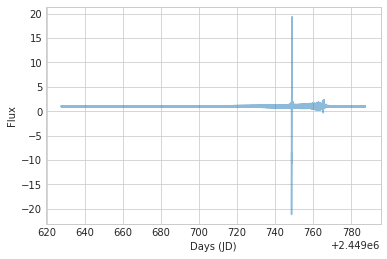

In [2]:
asteroid = '3200' # there are 3 other asteroids to test if you want

true_log_p = {'3200':-1.896021, '1291':-1.45813055, 
              '221':-0.8321219, '1388':-0.69789175}
true_p = {'3200':3.603957/24, '1291':5.58410/24, 
              '221':10.443/24, '1388':11.9432/24}

# read in the data
txt = '../data/'+str(asteroid)+'_lc_49627_to_49787.txt'
data = pd.read_csv(txt, delimiter=' ', header=None, 
                   names=['time','flux'], 
                   dtype={'time':float, 'flux':float})

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(data.time, data.flux, alpha=0.5)
ax.set_xlabel("Days (JD)")
ax.set_ylabel("Flux")

## Dense (3 days)

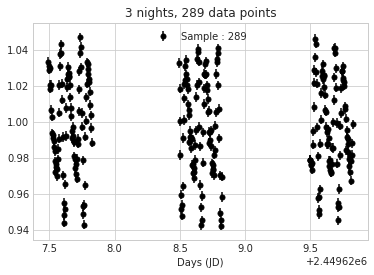

In [4]:
days, delay = 3, 0

# convert days to points
span = 2880 * days
start_pt = 2880 * delay

time = np.array(data.time[start_pt:span+start_pt])
flux = np.array(data.flux[start_pt:span+start_pt])

flux_err = np.ones_like(flux) * np.std(flux)/10.0
tsample, fsample, flux_err = subsample(time, flux, flux_err=flux_err, npoints=100, kind="dense")

fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.set_title("%i nights, %i data points"%(days, len(fsample)))
ax.set_xlabel("Days (JD)")
ax.errorbar(tsample, fsample, yerr=flux_err, fmt="o", markersize=5,
            color="black", zorder=10, 
            label="Sample : " + str(len(tsample)))
ax.legend()

In [18]:
ndim, nwalkers = 4, 100

In [19]:
# initialize walker parameters
gp_mean = np.mean(fsample)
log_amp = np.log(fsample.max()-fsample.min())
gamma = 1
log_period = best_log_period

params = [np.mean(fsample), log_amp, gamma, log_period]

# set up gp kernel
kernel = np.exp(log_amp) * george.kernels.ExpSine2Kernel(gamma = gamma, log_period = log_period)
gp = george.GP(kernel, fit_mean=True, mean=gp_mean)
gp.compute(tsample, flux_err)

# equally distributed starting period values
p_start = np.array(params)/100.
cov_matrix = np.sqrt(np.diag(p_start)**2)
p0 = np.random.multivariate_normal(mean=params, cov=cov_matrix, size=(nwalkers))
x = np.log(np.linspace(2,12,nwalkers)/24.)
p0[:,3] = x


In [20]:
threads=10
sampler = emcee.EnsembleSampler(nwalkers, ndim, post_lnlikelihood, args=[gp, tsample, fsample, flux_err], threads=threads)

/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log
/astro/users/cwlind/.conda/envs/gp

In [21]:
%%time
mcmc_sampling = sampler.run_mcmc(p0, 100)

CPU times: user 4.92 s, sys: 2.08 s, total: 7 s
Wall time: 2min 4s


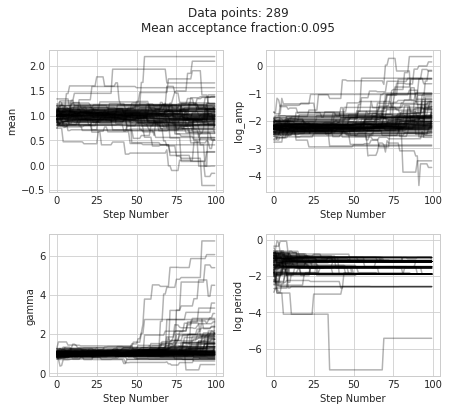

In [22]:
plot_steps(sampler, dims = ['mean', 'log_amp', 'gamma', 'log period'], p0=[params], data_pts=len(fsample))

Text(0.5,0,'Period (hours)')

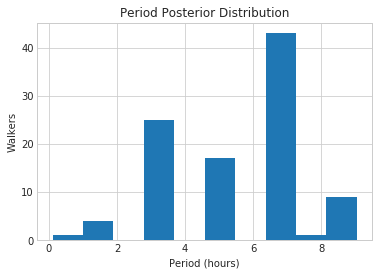

In [23]:
# sampler.chain[chain, step, dimension]
end_period = sampler.chain[:,-1,-1]
end_period.sort()

fig, fx = plt.subplots(1,1)
fx.hist(np.exp(end_period)*24.)
fx.set_title('Period Posterior Distribution')
fx.set_ylabel('Walkers')
fx.set_xlabel('Period (hours)')

In [38]:
def save_chain(file_name, sampler):
        header = str(sampler.chain.shape)
        np.savetxt(file_name, sampler.flatchain, header=header)
        return

#filename = txt+"_ztf-lsst_norm"

#save_chain(filename + "_results.txt", sampler)

[ 1.11449426 -2.29562159  1.02870924 -1.9062303 ]
[ 1.58663125 -2.9448117   0.95669433 -1.48559616]
[ 1.02965    -2.91080073  0.98964596 -1.89544304]
[ 0.81817079 -2.02564601  1.35979229 -1.55988798]
[ 0.66161075 -1.99538616  1.01432018 -1.48653515]
[ 0.964344   -2.42647864  0.96352959 -1.20769477]
[ 1.24160863 -2.51176209  1.08626179 -1.48767872]
[ 0.90237476 -2.47162986  0.93621168 -1.19940322]
[ 0.98390409 -2.26324438  1.09224027 -1.20317043]
[ 1.08024536 -2.47147857  0.96147448 -2.59178987]


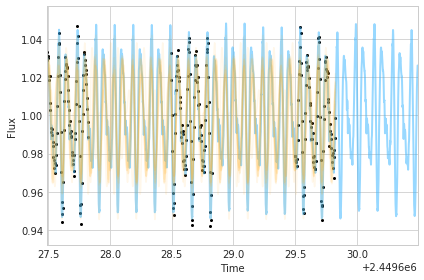

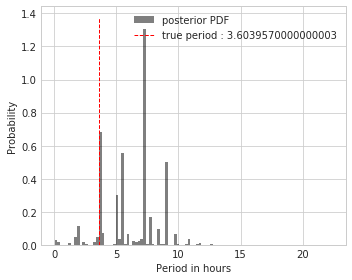

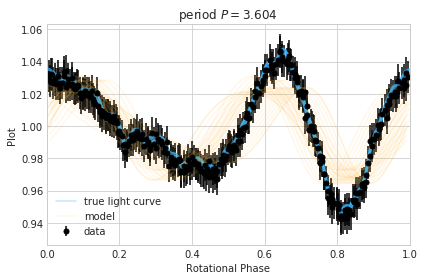

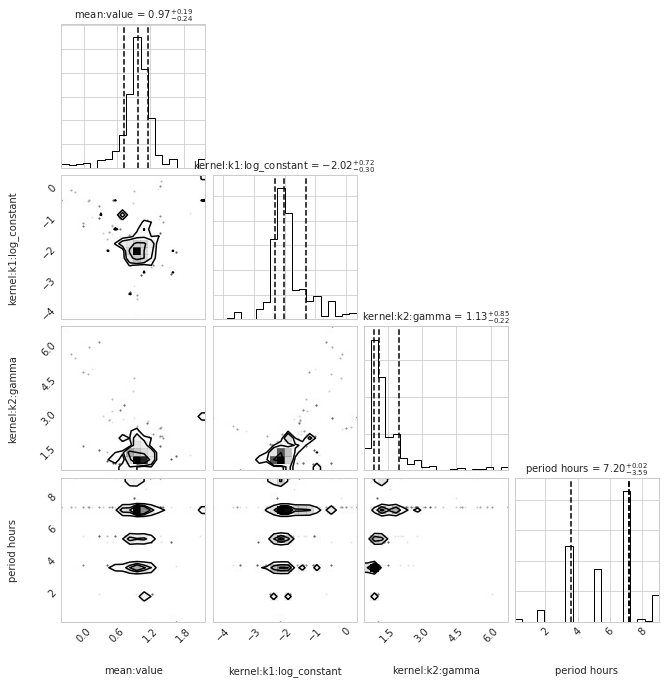

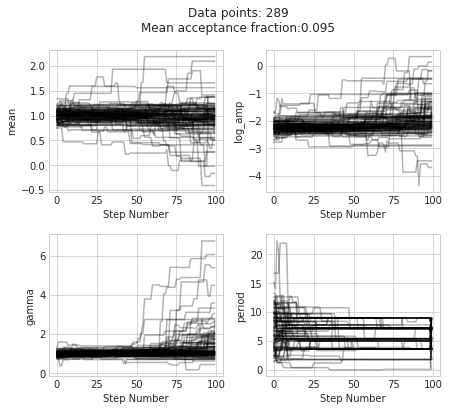

In [24]:
filename = '3200_dense'
plot_mcmc_sampling_results(np.array(tsample), fsample, flux_err, gp, sampler, 
                           namestr=filename + "_plots", true_lightcurve=[time,flux], 
                           true_period=true_p['3200']*24.)

# Reversing Period 

In [44]:
#x = (np.exp(new_samples.T[3])*24.)
x = np.log(sampler.flatchain.T[3]/24.)
x

array([-2.58637054, -2.58637054, -2.58637054, ..., -1.20291241,
       -1.20291241, -0.97972784])

In [45]:
sampler.flatchain.T[3] =x
sampler.flatchain.T[3]

array([-2.58637054, -2.58637054, -2.58637054, ..., -1.20291241,
       -1.20291241, -0.97972784])